In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow
import keras
import nltk
import gensim

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional,Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split

from scipy.cluster.vq import whiten

from collections import Counter

from gensim.models import Word2Vec
from gensim.models import FastText

from sklearn.metrics import f1_score

Using TensorFlow backend.


In [0]:
import string
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
import io
import matplotlib.pyplot as plt

from __future__ import print_function
from __future__ import division
import json
import numpy as np

from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Dropout, Flatten, Lambda, Embedding, LSTM,Bidirectional, concatenate, BatchNormalization 
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pickle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from pathlib import Path

path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
char=path/'Thesis Data'/'char-ulm'
wiki_data = path/'Thesis Data'/'wiki_data'/'Wiki'
we = path/'Thesis Data'/'WE'/'fastSKIP.pickle'

In [0]:
def load_ag_data(trainfile,testfile):
  
  onehotencoder = preprocessing.OneHotEncoder(categories='auto')

  ## TRAIN
  df = pd.read_csv(trainfile)
  df = df.dropna()
  df = df.sample(frac=1).reset_index(drop=True)#shuffle
  x_train = df['text'].tolist()
  y_train = onehotencoder.fit_transform((df['label'].values).reshape(-1,1)).toarray()

  ## TEST
  df = pd.read_csv(testfile)
  df = df.dropna()
  df = df.sample(frac=1).reset_index(drop=True)#shuffle
  x_test = df['text'].tolist()
  y_test = onehotencoder.transform((df['label'].values).reshape(-1,1)).toarray()

  return (x_train, y_train), (x_test, y_test)

In [0]:
def create_vocab_set(data,MAX_SEQUENCE_LENGTH=750):
    vocab=Counter()
    for i,s in enumerate(data):
      vocab.update(s.split())

    with open(we,"rb") as input_file:
      model = pickle.load(input_file)
    word_vectors = model.wv
    MAX_NB_WORDS = len(word_vectors.vocab)
    nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab)) + 1
    word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
    return vocab,word_index,nb_words,word_vectors,MAX_NB_WORDS

In [0]:
def encode_data(x, word_index, mxlen):
#   ret = [[word_index.get(t, 0) for t in sent.split() ] for sent in x]
  ret = []
  for sent in x:
    ls = [word_index.get(t, 0) for t in sent.split()]
    # padding
    if len(ls)>=mxlen:
      ls = ls[:mxlen]
    else :
      ls=ls+[0]*(mxlen-len(ls))
    ret.append(ls)
  return np.array(ret)

In [0]:
def form_we_matrix(word_index,nb_words,word_vectors,MAX_NB_WORDS,WV_DIM=300):
  # we initialize the matrix with random numbers
  wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

  for word, i in word_index.items():
      if i >= MAX_NB_WORDS:
          continue
      try:
          embedding_vector = word_vectors[word]
          wv_matrix[i] = embedding_vector
      except:
          pass
  return wv_matrix

## Model

In [0]:
def create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output, w, WV_DIM=300):
    
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    # Define what the input shape looks like
    inputs = Input(shape=(maxlen,), dtype='int64')

    # print(w)
    embedded = Embedding(input_dim=vocab_size, output_dim=WV_DIM , weights=[w])(inputs)

    # All the convolutional layers...
    conv = Convolution1D(filters=nb_filter[0], kernel_size=filter_kernels[0], kernel_initializer=initializer,
                         padding='valid', activation='relu',
                         input_shape=(maxlen, vocab_size))(embedded)
    conv = MaxPooling1D(pool_size=3)(conv)

    conv1 = Convolution1D(filters=nb_filter[1], kernel_size=filter_kernels[1], kernel_initializer=initializer,
                          padding='valid', activation='relu')(conv)
    conv1 = MaxPooling1D(pool_size=3)(conv1)

    lstm=Dropout(0.5)(LSTM(100)(conv1))
    z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(lstm))

    # Output dense layer with softmax activation
    pred = Dense(cat_output, activation='softmax', name='output')(z)

    model = Model(inputs=inputs, outputs=pred)

    adam = Adam(lr=0.001, decay=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model


In [0]:
def CNN_LSTM(trainfile,testfile,aa,cat_output):
  np.random.seed(123)  # for reproducibility
  # Maximum length. Longer gets chopped. Shorter gets padded.
  maxlen = 750
  # Model params
  # Filters for conv layers
  nb_filter = [128,256]
  # Number of units in the dense layer
  dense_outputs = 512
  # Conv layer kernel size
  filter_kernels = [7, 3]
  # Compile/fit params
  batch_size = 128
  nb_epoch = 15

  print('Loading data...')
  (xt, yt), (x_test, y_test) = load_ag_data(trainfile,testfile)

  print('Creating vocab...')
  vocab,word_index,nb_words,word_vectors,MAX_NB_WORDS = create_vocab_set(xt)

  print('Form Word Embedding Matrix...')
  w = form_we_matrix(word_index,nb_words,word_vectors,MAX_NB_WORDS)
  print("word embedding shape = ",w.shape)
  
  print('Build model...')
  model = create_model(filter_kernels, dense_outputs, maxlen, nb_words, nb_filter, cat_output,w)
  
  print('Encode data...')
  xt = encode_data(xt, word_index, maxlen)
  x_test = encode_data(x_test, word_index, maxlen)

  model.summary()
  print('Fit model...')
  hist = model.fit(xt, yt, validation_split=0.2 , batch_size=batch_size, epochs=nb_epoch, shuffle=True)

  history = pd.DataFrame(hist.history)
  plt.figure(figsize=(12,12));
  plt.plot(history["loss"],label='loss');
  plt.plot(history["val_loss"], label='val-loss');
  plt.title("Loss with trained word vectors");
  plt.legend();
  # plt.show();
  plt.savefig(aa+'loss.eps')
  
  Y_pred = model.predict(x_test)
  y_pred = np.argmax(Y_pred, axis=1)
  y_test = np.argmax(y_test,axis=1)
  # print(y_pred)
  # print(y_test)
  acc = (y_test==y_pred).sum()/len(y_pred)
  f1 = f1_score(y_test, y_pred, average='macro')
  print("Accuracy=",acc," F1=",f1)
  cm=confusion_matrix(y_test, y_pred)
  print(cm)

  df_cm = pd.DataFrame(cm, range(cat_output),range(cat_output))
  plt.figure(figsize = (10,7))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size
  plt.savefig(aa+'cm.eps')
  
  return model

## AA2

Loading data...
Creating vocab...
Form Word Embedding Matrix...
word embedding shape =  (59959, 300)
Build model...
Encode data...
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 750)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 750, 300)          17987700  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 744, 128)          268928    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 248, 128)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 246, 256)          98560     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 82, 256)           0    

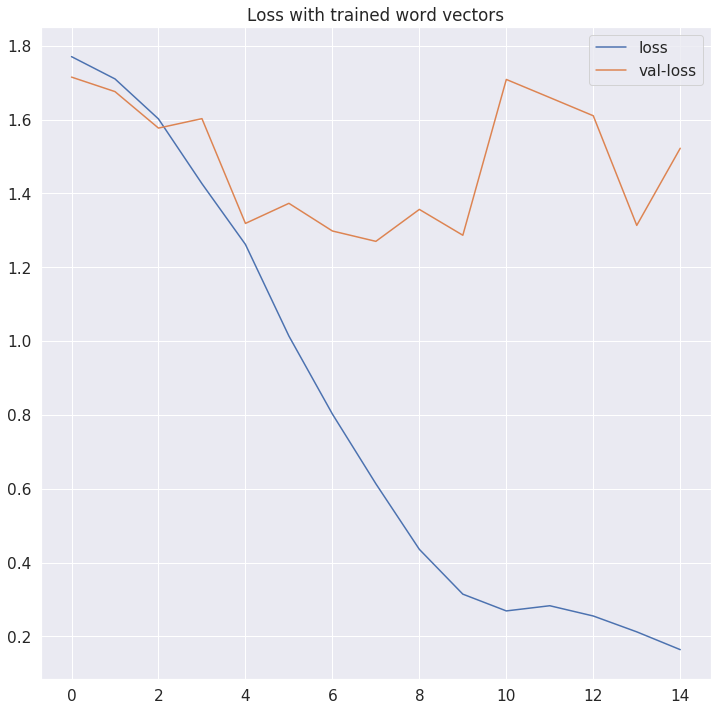

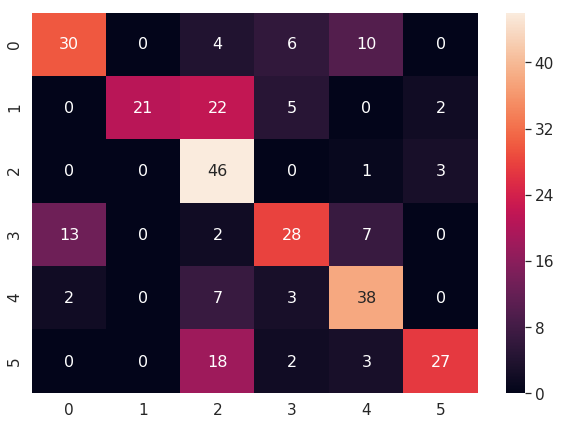

In [17]:
model = CNN_LSTM(aa2/'ulm_train.csv',aa2/'ulm_test.csv','aa2',6)

## AA

Loading data...
Creating vocab...
Form Word Embedding Matrix...
word embedding shape =  (59959, 300)
Build model...
Encode data...
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 750)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 750, 300)          17987700  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 744, 128)          268928    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 248, 128)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 246, 256)          98560     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 82, 256)           0    

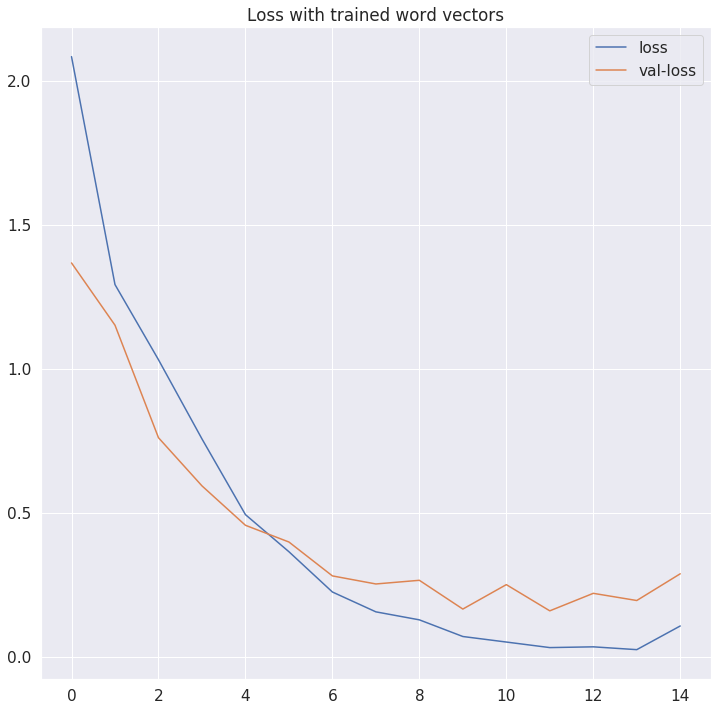

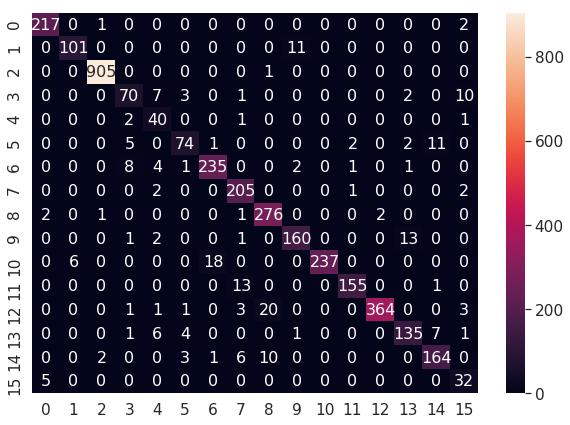

In [15]:
model = CNN_LSTM(aa/'OurDataset_train.csv',aa/'OurDataset_test.csv','aa',16)